In [2]:
# Bibliotecas de uso geral
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [29]:
#
# Nesse problema nós temos dois conjuntos que estão relacionados pela 
# coluna anime_id.
#

# Carregando os dados dos animes 
df_anime = pd.read_csv('bases/recommendation/anime/anime.csv')

# Carregando as notas por usuário
df_rating = pd.read_csv('bases/recommendation/anime/rating.csv')

(7813737, 3)

In [30]:
#
# Os dois conjuntos tem uma coluna que leva o mesmo nome,
# que é a coluna de nota rating, que tem significados
# diferentes. Na conjunto anime o rating está relacionado ao anime
# enquanto no conjunto rating a relação é com os usuários.
#
df_rating = df_rating.rename({'rating':'user_rating'}, axis='columns')

#
# Vamos remover entradas de usuários com menos de 5 pontos de nota, pois
# a contribuição deles é pouca, e queremos encontrar filmes com boa 
# pontuação geral. Essa parte é meio heurística, poderíamos por
# exemplo utilizar a média das notas dos filmes assistidos por usuário.
#
df_rating = df_rating.drop(df_rating[df_rating.user_rating < 5].index)

In [31]:
#
# Número de amostras com rating >= 5
#
df_rating.shape

(6151698, 3)

In [20]:
#
# Muitos animes estão sem notas e outros dados, mas
# nesse caso já esperamos isso, afinal sistemas de
# recomendação trabalham com bases incompletas.
#
df_anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [37]:
#
# Agora vamos fazer um join dos conjuntos.
#
df_merge = pd.merge(df_anime, df_rating, on=['anime_id','anime_id'])

#
# Nós temos 6151696 amostras no DataFrame df_merge,
# vamos reduzir o número de usuários para que 
# possamos rodar o k-means em um tempo menor.
# Se você tiver recursos use o conjunto todo.
#
df_merge = df_merge[df_merge.user_id <= 10000] 

#
# Tivemos uma redução na variação de animes, mas 
# podemos aumentar depois e fazer novos testes.
# Apesar disso ainda temos um bom número.
#
print('Variações de animes com todo conjunto : ', len(df_merge['anime_id'].unique()))
print('Variações de animes com o conjunto reduzido : ', len(df_anime['anime_id'].unique()))

Variações de animes com todo conjunto :  7809
Variações de animes com o conjunto reduzido :  12294


In [38]:
#
# Essa abordagem que vamos utilizar é a mais comum em
# sistemas de recomendação, nosso conjunto de 
# características se transforma em um problema de
# características binárias, resultando em uma
# matriz esparsa. Porém, poderiamos utilizar
# o rating do usuário, é uma outra estratégia. Alguns
# trabalhos indicam que as ideias são equivalentes.
#
#
# A função croostab do pandas gerar uma tabela de freqûencias
# no nosso caso entre o id do usuário e o nome do anime
# cada linha vai ter o id e os anime assistidos, cada um 
# marcado com 1. 
#
df_X = pd.crosstab(df_merge['user_id'], df_merge['name'])
df_X.head()

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,gdgd Fairies 2,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,iDOLM@STER Xenoglossia Specials,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
#
# Números de usuários 
#
np.size(df_merge['user_id'].unique())

9458

[]

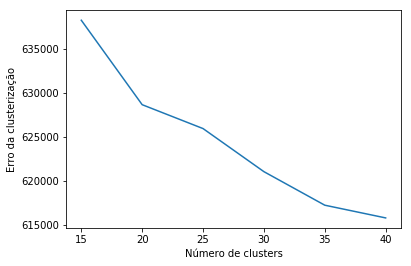

In [87]:
#
# Vamos utilizar kmeans para clusterizar os usuários de acordo com nossa
# tabela de freqûencias. Para escolher o número k de clusters, vamos utilizar
# o custo do clusters. Esse parâmetro está disponível no atributo inertia_
#
from sklearn.cluster import KMeans

#
# Vamos construir clusters maiores
#
K = [15, 20, 25, 30, 35, 40]

# Armazenar o erro dos clusters por k \in K
erro = []

# Rodando o kmeans
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_X)
    erro.append(kmeans.inertia_)
    
# Plotando erro
plt.plot(K, erro)
plt.xlabel('Número de clusters')
plt.ylabel('Erro da clusterização')
plt.plot()

In [96]:
#
# Treinando o kmeans com 30 clusters
#
kmeans = KMeans(n_clusters=30)
kmeans.fit(df_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [100]:
#
# Vamos pegar as predições de cada cluster para nosso conjunto
#
Y = kmeans.predict(df_X)

In [198]:
# Usuários que fazem parte do nosso conjunto
usuarios_clusterizados = df_merge['user_id'].unique()

# Vamos escolher um usuário qualquer
user = usuarios_clusterizados[1300]
print('Usuário escolhido :', user)

# Vamos pegar o cluster desse usuário
c_user = Y[df_X.index.get_loc(user)]

# Dados do usuário
user_data = df_X.loc[df_X.index.get_loc(user), :]

# Filmes ainda não vistos
user_not_seem = user_data[user_data == 0]

# Novos animes!
new_animes = pd.concat([user_not_seem, df_X[Y == c_user].mean()], axis=1, join='inner').loc[:,0]

# A primeira coisa é recomendar top 15 animes baseado no cluster de c_user
print('-----------------------------------------------------------------')
print('Top 15 Animes recomendados:')
print('-----------------------------------------------------------------')
print(new_animes.sort_values(ascending=False)[0:15])

Usuário escolhido : 3398
-----------------------------------------------------------------
Top 15 Animes recomendados:
-----------------------------------------------------------------
name
Sword Art Online                                       0.825077
Angel Beats!                                           0.719814
No Game No Life                                        0.702786
Toradora!                                              0.678019
Chuunibyou demo Koi ga Shitai!                         0.600619
Mirai Nikki (TV)                                       0.589783
Death Note                                             0.585139
Steins;Gate                                            0.575851
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.571207
High School DxD                                        0.560372
Sakurasou no Pet na Kanojo                             0.560372
Boku wa Tomodachi ga Sukunai                           0.540248
Highschool of the Dead                    

In [228]:
# Criando meu usuário
df_xi = pd.DataFrame(np.zeros(shape=(1,df_X.columns.shape[0])), columns=df_X.columns)

# Eu gosto muito de Death Note então vamos ver o que o sistema me recomenda baseado apenas nisso
df_xi['Death Note'] = 1

df_xi.index.name = 'user_id'

# Vamos predizer baseado nos demais clusters
y_i = kmeans.predict(df_xi)

# Meus dados
user_data = df_xi.loc[0, :]

# Animes ainda não vistos
user_not_seem = user_data[user_data == 0]

# Novos animes!
new_animes = pd.concat([user_not_seem, df_X[Y == y_i].mean()], axis=1, join='inner').loc[:, 0]
new_animes.columns = ['not_seem', 'clusters_mean']
new_animes = new_animes.drop('not_seem', axis=1)

# A primeira coisa é recomendar top 15 animes baseado no cluster de c_user
print('-----------------------------------------------------------------')
print('Top 15 Animes recomendados:')
print('-----------------------------------------------------------------')
print(new_animes.sort_values(by='clusters_mean',ascending=False)[0:15])

-----------------------------------------------------------------
Top 15 Animes recomendados:
-----------------------------------------------------------------
                                    clusters_mean
name                                             
Shingeki no Kyojin                       0.167960
Sword Art Online                         0.160903
Naruto                                   0.148200
Ouran Koukou Host Club                   0.128676
Fullmetal Alchemist                      0.112209
Code Geass: Hangyaku no Lelouch          0.103740
Fullmetal Alchemist: Brotherhood         0.102094
Elfen Lied                               0.100212
Sen to Chihiro no Kamikakushi            0.099976
Angel Beats!                             0.097624
Toradora!                                0.082098
Code Geass: Hangyaku no Lelouch R2       0.080687
Soul Eater                               0.076923
Kuroshitsuji                             0.076217
Ao no Exorcist                          